![Alt text](https://miro.medium.com/v2/resize:fit:1400/1*hsyCZOYoGrX6BJsj4Lgrhg.png)

## Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df=pd.read_csv('spam.csv')

## Check Data

In [152]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [154]:
df.duplicated().sum()

415

In [155]:
df.drop_duplicates(inplace=True)

In [156]:
df.duplicated().any()

False

In [157]:
df.isna().sum()

Category    0
Message     0
dtype: int64

In [158]:
df[df['Category']=='ham'].sample(n=10)  # Take a sample of rows

,Category,Message
2572,ham,… and don‘t worry we‘ll have finished by march...
3765,ham,Would me smoking you out help us work through ...
3321,ham,Eh sorry leh... I din c ur msg. Not sad alread...
4800,ham,I dont know why she.s not getting your messages
38,ham,Anything lor... U decide...
3523,ham,Im sorry bout last nite it wasnt ur fault it ...
153,ham,Ok... Ur typical reply...
1230,ham,Jus ans me lar. U'll noe later.
3704,ham,How is my boy? No sweet words left for me this...
3031,ham,"Also sir, i sent you an email about how to log..."


In [159]:
df[df['Category']=='spam'].sample(n=10)  # Take a sample of  rows

,Category,Message
114,spam,GENT! We are trying to contact you. Last weeke...
463,spam,"UpgrdCentre Orange customer, you may now claim..."
5137,spam,YOU VE WON! Your 4* Costa Del Sol Holiday or £...
3725,spam,"Hi there, 2nights ur lucky night! Uve been inv..."
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
3529,spam,You are a £1000 winner or Guaranteed Caller Pr...
3646,spam,wamma get laid?want real doggin locations sent...
4020,spam,U've been selected to stay in 1 of 250 top Bri...
1423,spam,Congratulations ur awarded either £500 of CD g...
4166,spam,"Dear Voucher Holder, To claim this weeks offer..."


In [160]:
df2=df

In [161]:
def calculate_counts(text):
    num_words = len(nltk.word_tokenize(text))
    num_sentences = len(nltk.sent_tokenize(text))
    num_characters = len(text)
    return pd.Series([num_words, num_sentences, num_characters])

# Apply the function to the 'message' column
df2[['Word count', 'Sentence count', 'Character count']] = df['Message'].apply(calculate_counts)

df2

,Category,Message,Word count,Sentence count,Character count
0,ham,"Go until jurong point, crazy.. Available only ...",24,2,111
1,ham,Ok lar... Joking wif u oni...,8,2,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,37,2,155
3,ham,U dun say so early hor... U c already then say...,13,1,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",15,1,61
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,35,4,160
5568,ham,Will ü b going to esplanade fr home?,9,1,36
5569,ham,"Pity, * was in mood for that. So...any other s...",15,2,57
5570,ham,The guy did some bitching but I acted like i'd...,27,1,125


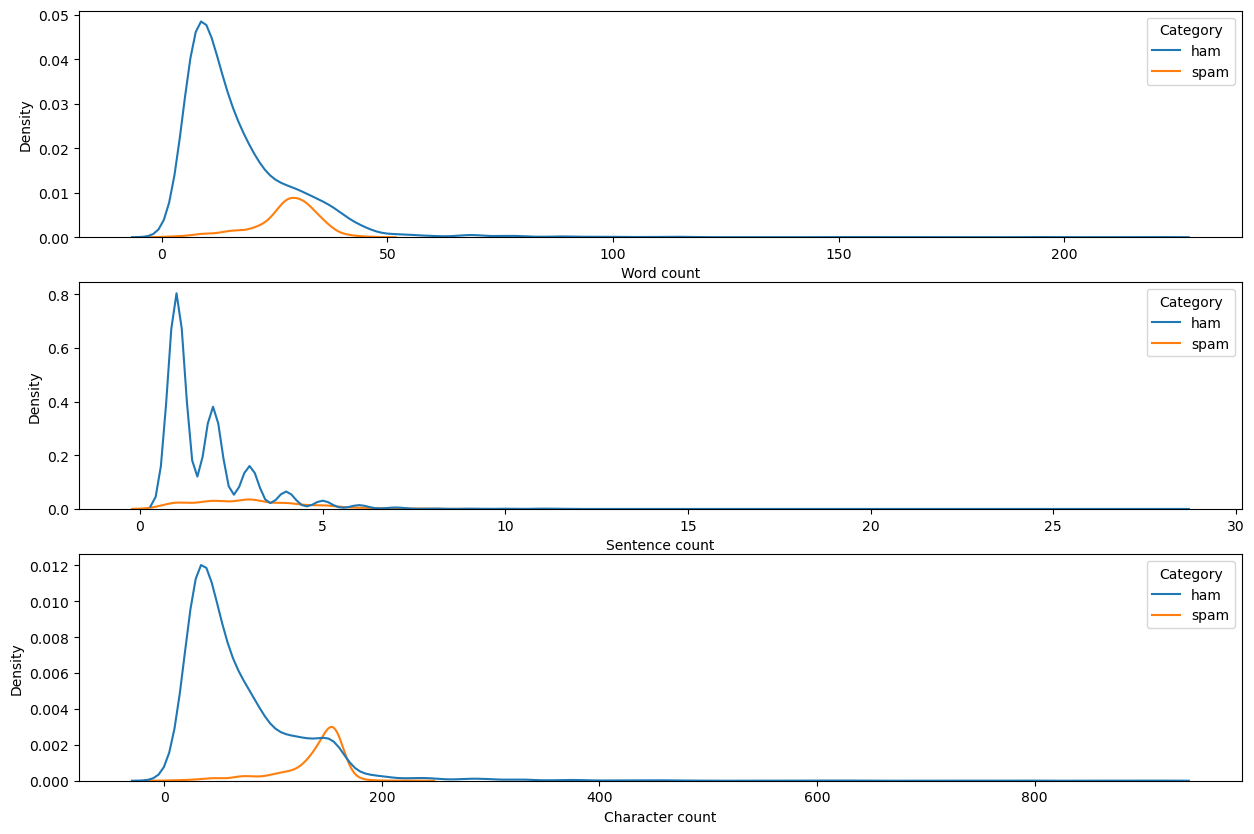

In [162]:
fig ,axs=plt.subplots(3,1,figsize = (15,10))
sns.kdeplot(data=df2,x=df2['Word count'],hue='Category',ax=axs[0])
sns.kdeplot(data=df2,x=df2['Sentence count'],hue='Category',ax=axs[1])
sns.kdeplot(data=df2,x=df2['Character count'],hue='Category',ax=axs[2])
plt.show()

## Preprocessing

In [163]:
df2['Message'] = df2['Message'].str.lower()

# Remove extra white spaces from the 'Text' column
df2['Message'] = df2['Message'].str.strip()


# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'Text' column
df2['Message'] = df2['Message'].apply(remove_stopwords)


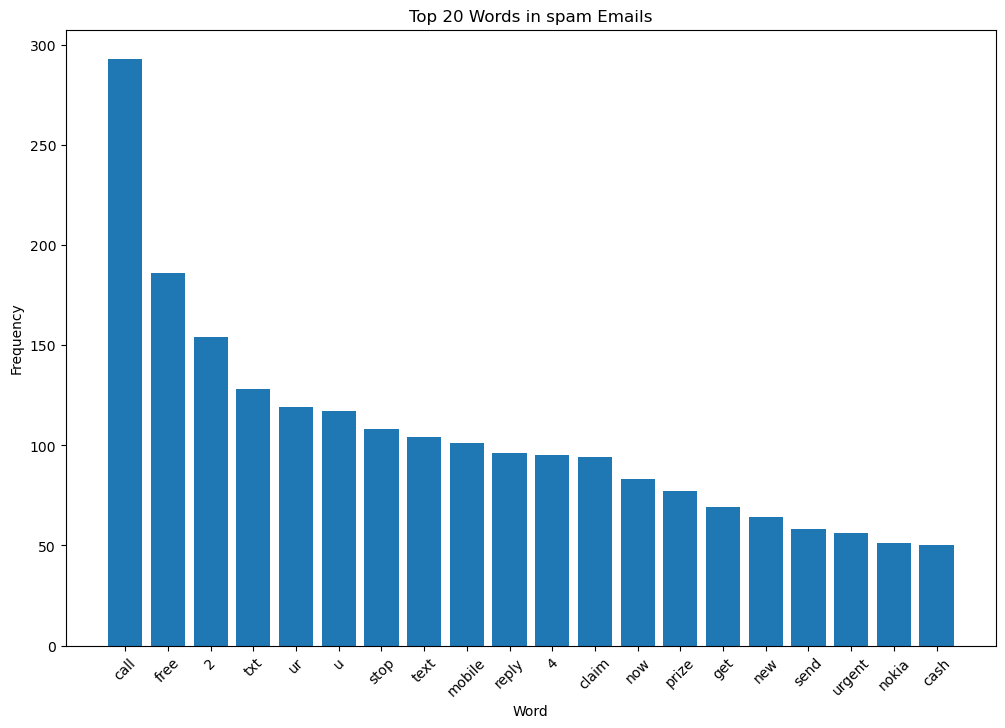

In [164]:
# Filter spam messages
spam_messages = df[df['Category'] == 'spam']['Message']

words = []

for message in spam_messages:
    tokens = word_tokenize(message)
    filtered_words = [word for word in tokens if word.isalnum()]
    words.extend(filtered_words)

# Count word frequencies
word_freq = Counter(words)

# Convert to DataFrame for plotting
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
plt.bar(word_freq_df['Word'][:20], word_freq_df['Frequency'][:20])  # Top 20 words
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Words in spam Emails')
plt.xticks(rotation=45)
plt.show()

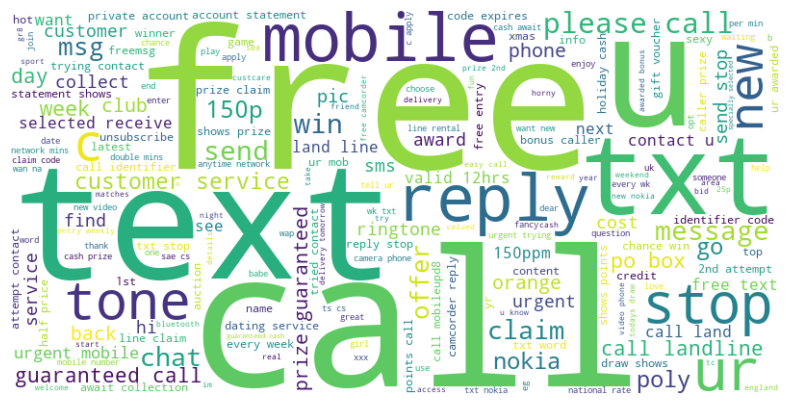

In [165]:
spam_messages = df[df['Category'] == 'spam']['Message']

# Tokenize words and 
words = []
for message in spam_messages:
    tokens = word_tokenize(message.lower())
    filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]
    words.extend(filtered_words)

# Join words into a single string
text = ' '.join(words)

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

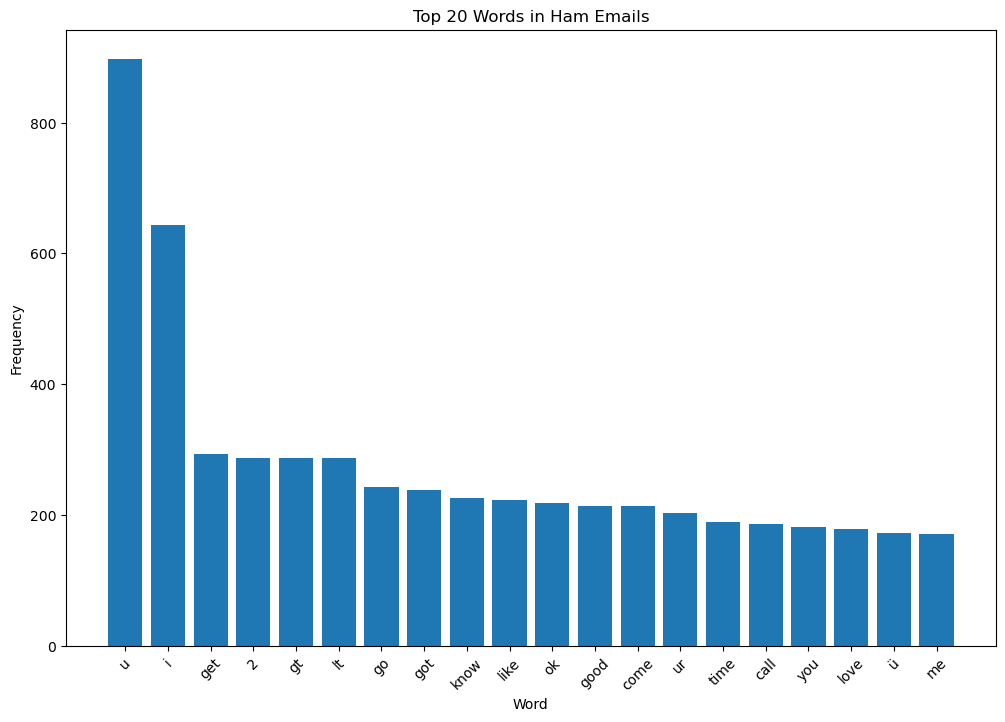

In [166]:

# Filter ham messages
spam_messages = df[df['Category'] == 'ham']['Message']

words = []

for message in spam_messages:
    tokens = word_tokenize(message)
    filtered_words = [word for word in tokens if word.isalnum()]
    words.extend(filtered_words)

# Count word frequencies
word_freq = Counter(words)

# Convert to DataFrame for plotting
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
plt.bar(word_freq_df['Word'][:20], word_freq_df['Frequency'][:20])  # Top 20 words
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Words in Ham Emails')
plt.xticks(rotation=45)
plt.show()

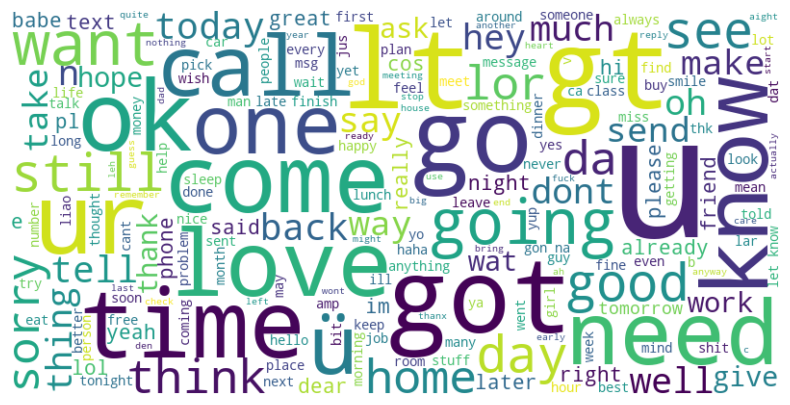

In [167]:
spam_messages = df[df['Category'] == 'ham']['Message']

# Tokenize words 
words = []

for message in spam_messages:
    tokens = word_tokenize(message.lower())
    filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]
    words.extend(filtered_words)

# Join words into a single string
text = ' '.join(words)

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

In [168]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df2['Category'] = label_encoder.fit_transform(df2['Category'])

## Split Data

In [169]:
X= df2['Message']
y=df2['Category']

In [170]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)    

## Modeling

In [171]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the text data
X_train_trans = vectorizer.fit_transform(X_train)
X_test_trans = vectorizer.transform(X_test)

In [172]:
# Define classification models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "SGD Classifier": SGDClassifier(),
    "CLF": MultinomialNB()
    
}
results = []

for name, model in models.items():
    model.fit(X_train_trans, y_train)
    y_pred = model.predict(X_test_trans)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        "Model Name": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


In [173]:
results_df

,Model Name,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.983527,0.983662,0.983527,0.983115
1,Random Forest,0.975775,0.976160,0.975775,0.974810
2,Gradient Boosting,0.972868,0.972888,0.972868,0.971839
3,Decision Tree,0.964147,0.964782,0.964147,0.964421
4,SVM,0.985465,0.985704,0.985465,0.985101
5,SGD Classifier,0.981589,0.981504,0.981589,0.981193
6,CLF,0.986434,0.986533,0.986434,0.986476


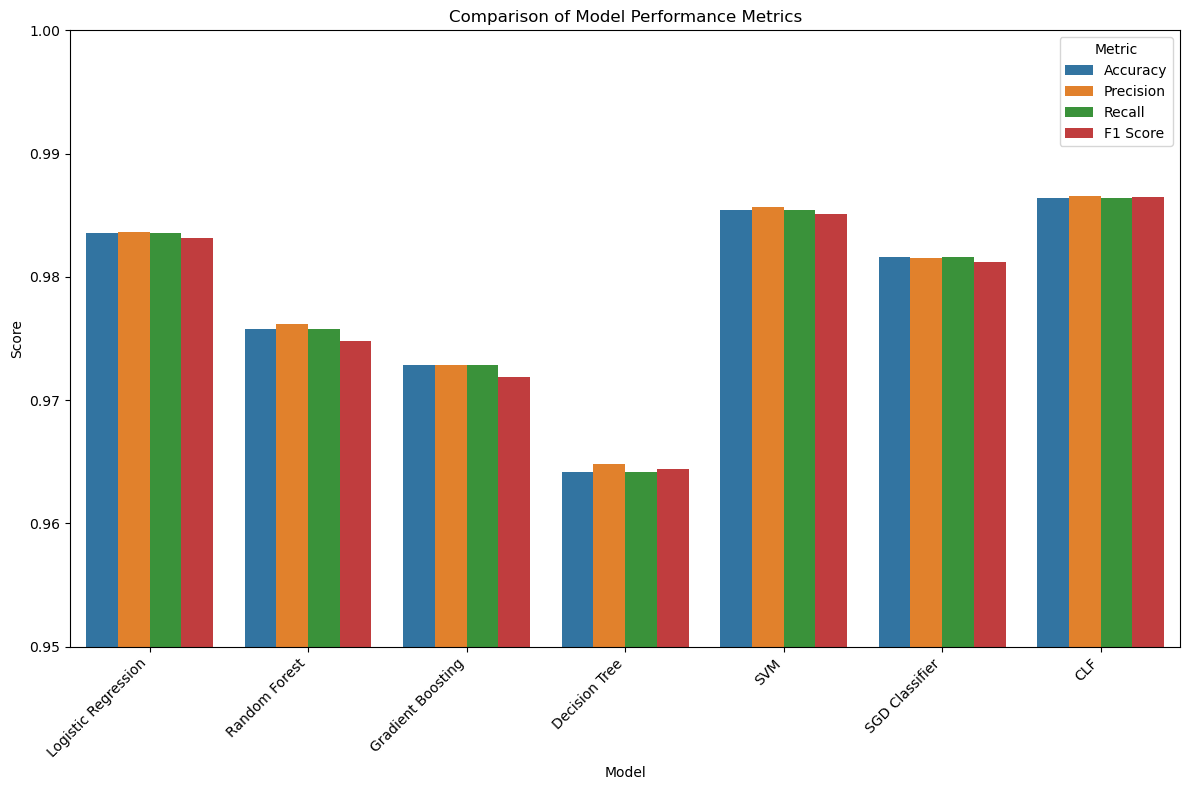

In [174]:
results_melted = pd.melt(results_df, id_vars="Model Name", 
                         value_vars=["Accuracy", "Precision", "Recall", "F1 Score"], 
                         var_name="Metric", value_name="Score")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=results_melted, x="Model Name", y="Score", hue="Metric")

# Rotate x labels for better readability
plt.xticks(rotation=45, ha="right")
plt.ylim(0.95, 1)
# Set plot titles and labels
plt.title("Comparison of Model Performance Metrics")
plt.xlabel("Model")
plt.ylabel("Score")

# Show the plot
plt.tight_layout()
plt.show()

## Predict Real Data

In [180]:
clf=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('clf',MultinomialNB())
])

In [181]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('clf', MultinomialNB())])

In [182]:
emails=[
    'Sounds great! Are you home now?',
    'Hey Sarah, are you available for a coffee chat this weekend?',
    'Claim your exclusive discount code now and save 30% on your next purchase! Limited time offer!',
    'Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES'
]

In [183]:
clf.predict(emails)

array([0, 0, 1, 1])